# Lab 3 — dimensionality reduction

In [59]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

##### First of all we extract genome-tags and create a dictionnary (tagID => movieName)

In [134]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)

tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

---

##### Then we extract the genome-scores and create a set of all movieID

In [136]:
scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
moviesId = set(scores.map(itemgetter("movieId")).collect())


nMovies = 27278
print("Number of movies without tags", nMovies - len(moviesId))

Number of movies without tags 16897


---

##### Now we create two dictionnaries :
- One (movieID => movieName)
- One (movieName => movieID)

In [138]:
id2movie = dict(enumerate(moviesId))
movie2id = {v: k for k, v in id2movie.items()}

---

##### We initialize 'matrix' which is the one containing the relevance of a tag with respect to a movie.
##### 'matrix' is initilized as (lines = tags, column = movies). It will be transpose later.

In [139]:
moviesList = np.sort(list(moviesId))
matrix = np.zeros((len(tag2name.keys()), len(moviesList)))

---

##### Now we want to fill our 'matrix'
###### For that we extract a 3-tuple list : (tagID, movieID, relevance), 
###### we create a dictionnary (tuple(tagID,movieID) => relevance),
###### and for all key in this dict we fill the corresponding matrix value.

In [140]:
tuple_list = scores.map(itemgetter("tagId", "movieId", "relevance")).collect()

In [141]:
getRelevance = {}

keys_list =[None] * len(tuple_list)
values_list = np.zeros(len(tuple_list))

for i in range(len(keys_list)):
    
    keys_list[i] = tuple_list[i][:2] # (tagID, movieID)
    values_list[i] = tuple_list[i][2] # Relevance
    
    getRelevance[keys_list[i]] = values_list[i]

In [142]:
#Filling
for tag in tag2name.keys():
    for movie in moviesList:
        matrix[tag-1][np.where(moviesList == movie)] = getRelevance[(tag, movie)]

---

##### Now we transpose the matrix so that it is tall, ie lines = movies and columns = tags. We also 'centralize'  it in order to take the covariance matrix

In [143]:
matrix = matrix.T

In [144]:
m = np.mean(matrix, axis =0)
matrix = matrix - m

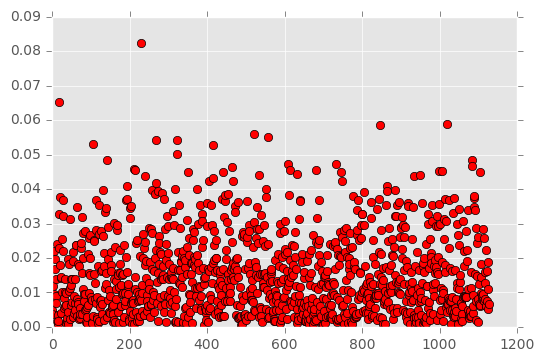

In [146]:
varByTag = np.var(matrix, axis=0)

plt.plot(varByTag, 'ro')
plt.show()

In [147]:
n=len(tag2name.keys())
covMatrix = np.cov(matrix.T)

---

###### Now let us extract the eigen values and vectors

In [73]:
eigVal, eigVect = np.linalg.eigh(covMatrix)

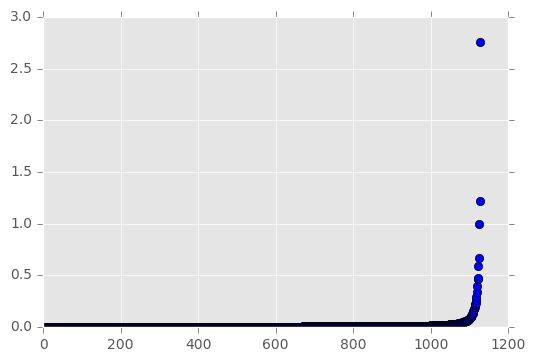

In [74]:
plt.plot(eigVal, 'bo')
plt.show()

In [148]:
total = np.sum(eigVal)

threshold = total*2/3
eigValReverse = np.flipud(eigVal)

sum = 0
i = -1

while(sum < threshold):
    i +=1
    sum += eigValReverse[i]
i+= 1
print("We only need", i, "eigenvalue to represent 2/3 of the variability")

We only need 37 eigenvalue to represent 2/3 of the variability


---

##### We now extract the 5 biggest eigVects and we project on those the film's relevances

In [152]:
five_main_eigvect = eigVect[:, len(eigVect) - 5: len(eigVect)]

films_in_new_space = matrix @ five_main_eigvect

---

###### Now for each eigen vector, we have the possibility to extract the name of the 5 tags that have the best and the worst relevance

In [161]:
orderedIndexes = np.argsort(five_main_eigvect ,axis = 0)

print("Eigen vector 0 is the most important")

for i in range(5):
    
    print("\nEigvect ", i)
    
    for j in range(5):
        print("min ", tag2name[orderedIndexes[j][4-i] + 1])
        
    for k in range(5):
        print("MAX ", tag2name[orderedIndexes[-5+k][4-i] + 1])

Eigen vector 0 is the most important

Eigvect  0
min  predictable
min  so bad it's funny
min  bad plot
min  silly
min  silly fun
MAX  great acting
MAX  imdb top 250
MAX  criterion
MAX  social commentary
MAX  talky

Eigvect  1
min  action
min  special effects
min  big budget
min  chase
min  fast paced
MAX  loneliness
MAX  melancholic
MAX  criterion
MAX  relationships
MAX  intimate

Eigvect  2
min  horror
min  weird
min  creepy
min  splatter
min  stylish
MAX  touching
MAX  heartwarming
MAX  love story
MAX  sentimental
MAX  feel-good

Eigvect  3
min  corruption
min  crime
min  murder
min  police investigation
min  thriller
MAX  scifi
MAX  sci-fi
MAX  imagination
MAX  visually stunning
MAX  visual

Eigvect  4
min  comedy
min  funny
min  hilarious
min  goofy
min  humorous
MAX  tense
MAX  suspenseful
MAX  secrets
MAX  conspiracy
MAX  thriller


###### Conclusions : We can see the folowing relations :
- Eigen vector 0 : good / bad movies
- Eigen vector 1 : blockbusters / touching movies
- Eigen vector 2 : stressful / feel-good movies
- Eigen vector 3 : thrillers / sci-fi movies
- Eigen vector 4 : funny / tense movies

---

###### Now we can see how much a tag is related to these 5 concepts

In [173]:
nameToNewSpace = {}

for i in range(len(five_main_eigvect)):
    
    
    # The '+1' is to compensate the 1-shift we made earlier that allowed to map line=0 to tagID=0
    nameToNewSpace[tag2name[i+1]] = five_main_eigvect[i]
    
    
nameToNewSpace["touching"]

array([-0.03988577,  0.03567739,  0.10182267,  0.00202905,  0.04046726])

---

###### We import the chosen movies and extract all the needed informations to have the Bokeh plot

In [165]:
with open("nameToNewSpace.pickle", "wb") as f:
    pickle.dump(nameToNewSpace, f)

In [167]:
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")

unique_identifier = 0
data = list()

for movie in movies:
    
    coordinates = films_in_new_space[movie2id[movie[0]]]
    
    # Create data used by Bokeh
    data.append((coordinates[3], coordinates[4], movie[1], movie[2], unique_identifier))
    
    unique_identifier += 1

In [168]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

---

###### Finally we draw the plot

- the legend : The brighter the color, the better the score

In [172]:
# Categorial colors : THESE PALETTES CONTAIN 256 COLORS !
from bokeh.palettes import Greys256


source = ColumnDataSource(
    data={
        "x": [x[0] for x in data],
        "y": [x[1] for x in data],
        "name": [x[2] for x in data],
        
        # Accessing the palette with an integer : 255 * grade_between_0_and_1
        "color": [(Greys256[int(x[3]*255)]) for x in data],
        
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="Films projected on the two main eigenvectors. The brighter the color, the better the mark")
circle = p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
glyph = circle.glyph
glyph.line_color = "black"
show(p, notebook_handle=True)

A few examples : 

- The Shawshank redemption is a very appriciated movie (number 1 on imbd) and is a quite intimate movie. That's why he's in the upper right corner.

- On the contrary, Miss congeniality 2 is not an action movie nor a sentimental movie but really got bad rating. Hence it is on the far left side, and in the middle of the screen